In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("D//Predict_Health_Insurance_Premium//notebooks//data//insurance.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'D//Predict_Health_Insurance_Premium//notebooks//data//insurance.csv'

In [3]:
data.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
data.shape

(1338, 7)

In [5]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [6]:
# Lets analyse categorical and numerical features separately
cat_cols = [cols for cols in data.columns if data[cols].dtype == 'object']
num_cols = [cols for cols in data.columns if data[cols].dtype != 'object']

In [7]:
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.00,27.0000,39.00,51.000,64.00
bmi,1338.0,30.665471,6.098382,16.00,26.3000,30.40,34.700,53.10
children,1338.0,1.094918,1.205493,0.00,0.0000,1.00,2.000,5.00
expenses,1338.0,13270.422414,12110.011240,1121.87,4740.2875,9382.03,16639.915,63770.43


1. Average age of individuals in data is 39 years.
2. Minimum age of individual is 18 years.
3. Around 75% of individuals in the dataset have age less that 51 years.
4. Average bmi of individuals is 30.
5. Around 75% of individuals in the dataset have 1 or 2 children.
6. Maximum expense on premium is Rs. 63770.
7. Minimum expense on premium is Rs. 1121.



In [8]:
data[cat_cols].describe().T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364


1. Maximum individuals in the data are Male.
2. Maximum individuals in the data are Non Smoker.
3. Maximum individuals in the data belongs to southeast region.

In [9]:
# Check if null values
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
expenses    False
dtype: bool

There are no null values in the data.

In [10]:
# Check for duplicate records
data.duplicated().sum()

1

In [11]:
# There is one duplicate record
data[data.duplicated()]

,age,sex,bmi,children,smoker,region,expenses
581,19,male,30.6,0,no,northwest,1639.56


In [12]:
# Drop the duplicate record
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(1337, 7)

### Univariate Analysis of continuous features

C:\Users\yashm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\yashm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\yashm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\yashm\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


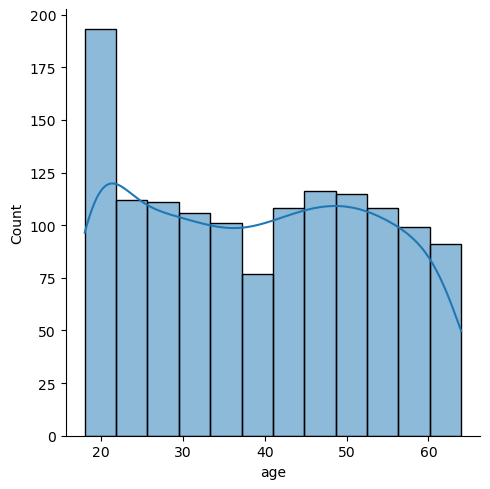

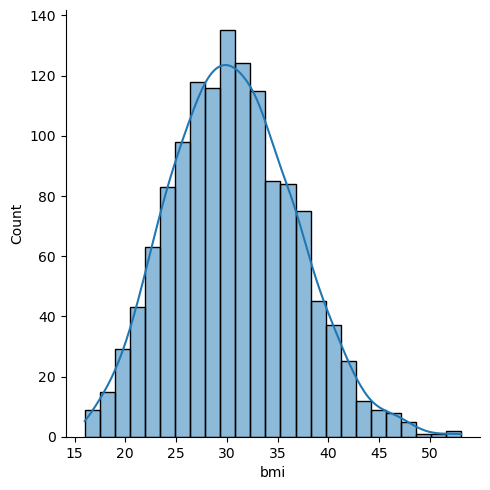

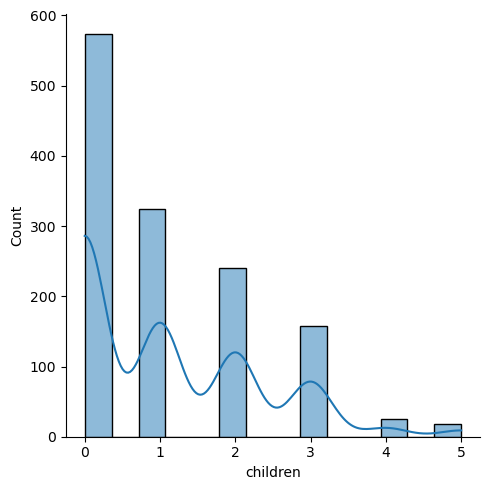

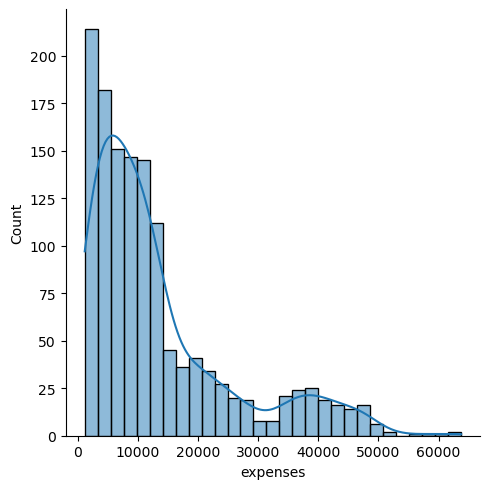

In [14]:
# function for distribution plot
def plot_distribution_plot(feature):
    #plt.figure(figsize=(5,5),layout='constrained')
    #plt.title(f'Distribution plot for {feature}')
    sns.displot(data=data,x= cols, kde = True)
    #plt.show()

for cols in data[num_cols]:
    plot_distribution_plot(cols)

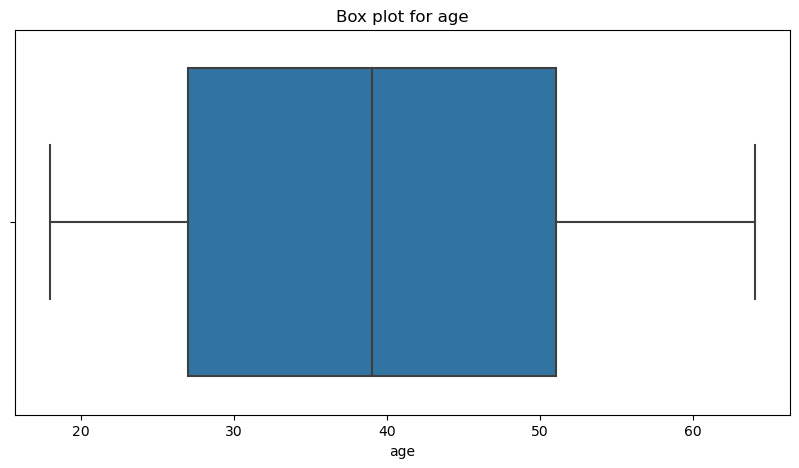

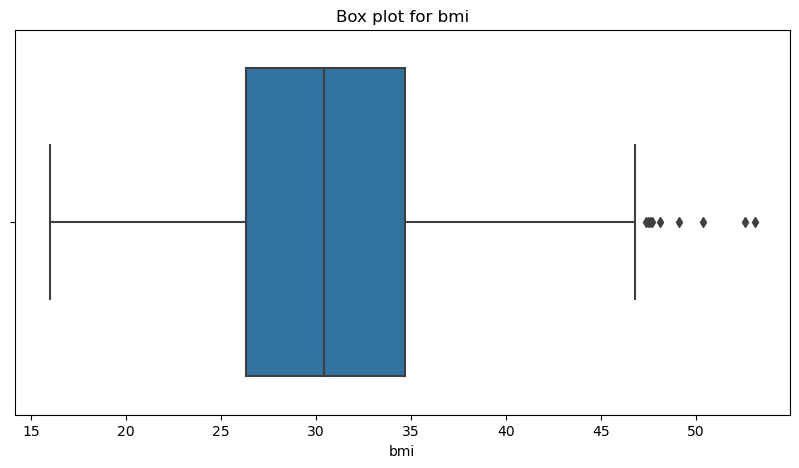

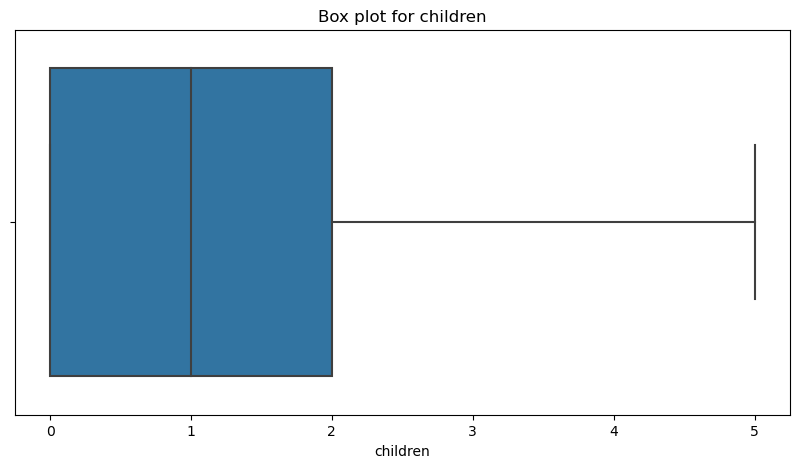

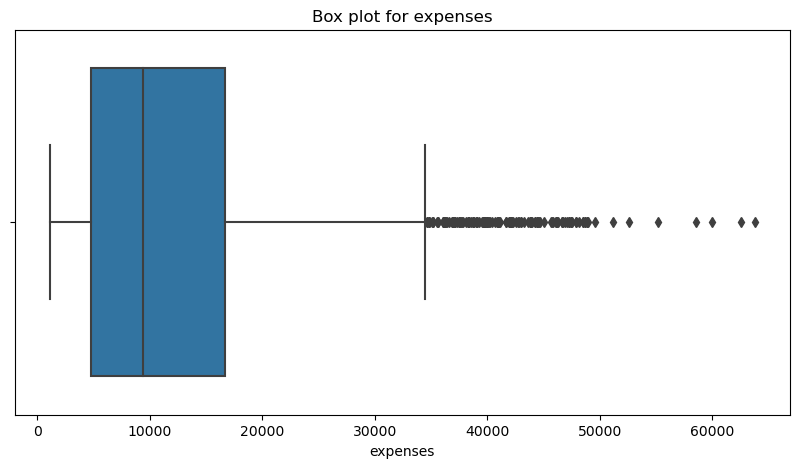

In [16]:
# function to plot box plot
def plot_box_plot(feature):
    plt.figure(figsize=(10,5))
    plt.title(f'Box plot for {feature}')
    sns.boxplot(data=data,x= cols)
    plt.show()

for cols in data[num_cols]:
    plot_box_plot(cols)

1. Feature bmi and expenses have outliers.
2. BMI above 45 can be considered as outlier.
3. Expenses above 35000 are outliers.

#### Handling Outliers

In [17]:
 # Handling outliers in BMI

# As BMI is normally distributed, we can use empirical rule to handle outliers
# Empirical rule states :
# 1. 66 % of data lies one std around mean.
# 2. 95 % of data lies two std around mean.
# 3. 99.7 % of data lies three std around mean.
# So data above three std can be considered as outlier.

bmi_mean = np.round(data['bmi'].mean(),2)
bmi_std = np.round(data['bmi'].std(),2)
bmi_outliers = []
for x in data['bmi']:
    x_z_score = (x - bmi_mean) / bmi_std
    if (x_z_score > 3):
        bmi_outliers.append(x)
bmi_outliers

[49.1, 50.4, 52.6, 53.1]

In [18]:
# lets calculate upper bound and lower bound value of BMI
Q1 = np.percentile(data['bmi'], 25)
Q3 = np.percentile(data['bmi'], 75)

print(f'Q1 is {Q1}')
print(f'Q3 is {Q3}')

IQR = Q3-Q1
print(f'IQR is {IQR}')
upper_bound = Q3 + (1.5 * IQR)
lower_bound = Q1 - (1.5 * IQR)

print(f'upper_bound is {upper_bound}')
print(f'lower_bound is {lower_bound}')


Q1 is 26.3
Q3 is 34.7
IQR is 8.400000000000002
upper_bound is 47.300000000000004
lower_bound is 13.699999999999998


In [19]:
# Replace outliers in BMI with upper bound
data.loc[data['bmi'] >= 49.1, 'bmi'] = upper_bound

In [20]:
# Handling outliers in expenses

Q1 = np.percentile(data['expenses'], 25)
Q3 = np.percentile(data['expenses'], 75)

print(f'Q1 is {Q1}')
print(f'Q3 is {Q3}')

IQR = Q3-Q1
print(f'IQR is {IQR}')
upper_bound = Q3 + (1.5 * IQR)
lower_bound = Q1 - (1.5 * IQR)

print(f'upper_bound is {upper_bound}')
print(f'lower_bound is {lower_bound}')

Q1 is 4746.34
Q3 is 16657.72
IQR is 11911.380000000001
upper_bound is 34524.79
lower_bound is -13120.73


In [21]:
# Replace outliers in expenses with upper bound value

data.loc[data['expenses'] >= 34524, 'expenses'] = upper_bound


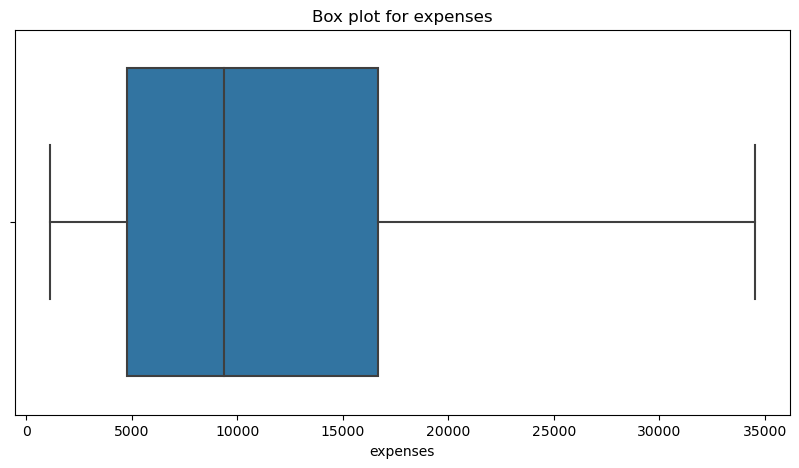

In [22]:
# After removing outliers in expenses
plot_box_plot('expenses')

### Univariate Analysis of Categorical Features

In [23]:
## Below function will plot countplot for the provided feature
def count_plot(feature):
    plt.figure(figsize=(10,5))
    ax = sns.countplot(data=data,x=feature)
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+2))
    plt.xticks(rotation=90)
    plt.show()

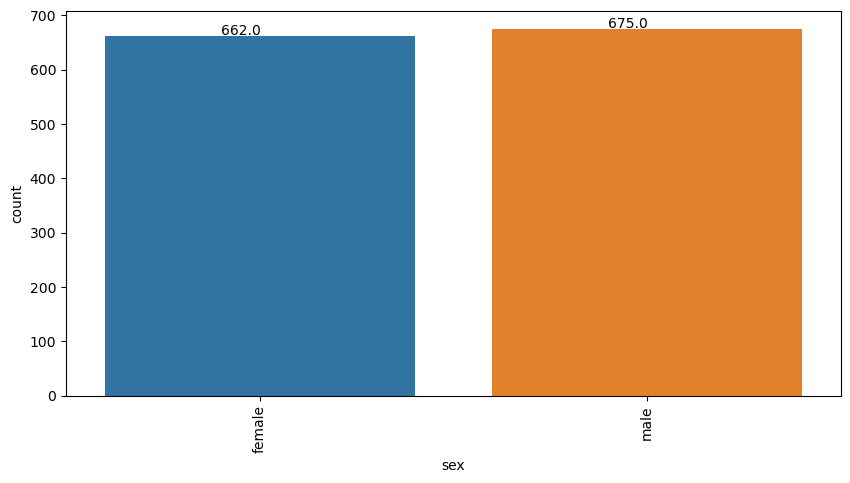

In [24]:
## Count plot for sex
count_plot("sex")

There are more number of males than females.

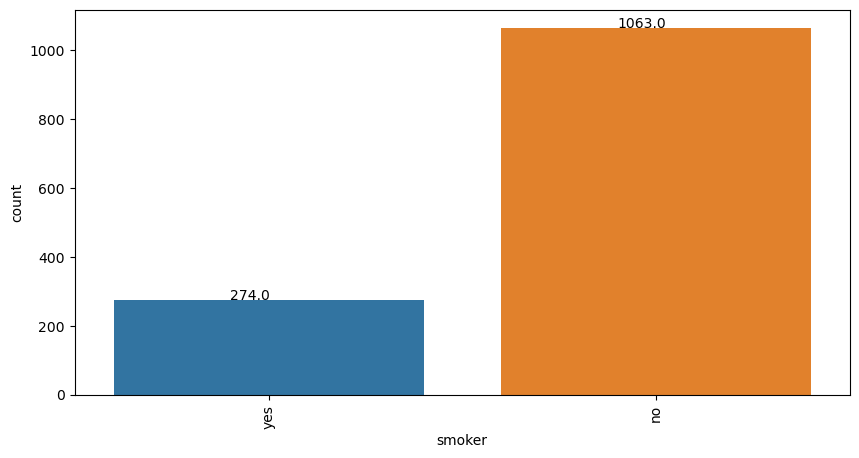

In [24]:
# Count plot for smoker
count_plot("smoker")

There are les number of smokers in the data.

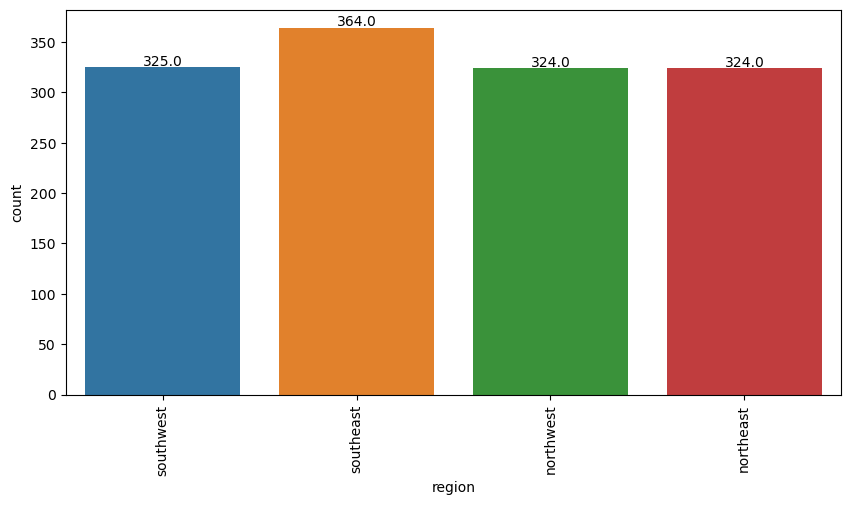

In [25]:
# Count plot for region
count_plot("region")

Most of the individuals in the data belongs to southeast region.

In [26]:
data['children'] = data['children'].apply(lambda x: 'yes' if x <=2 else 'no')

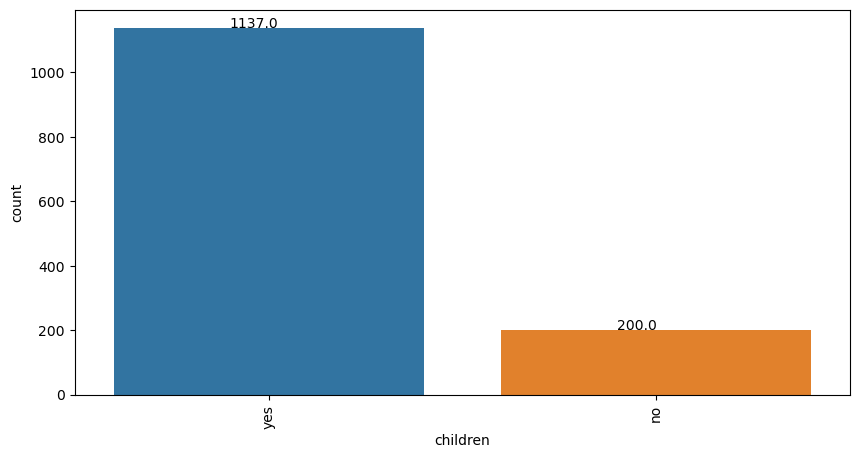

In [27]:
# Count plot for region
count_plot("children")

### Multivariate Analysis

Lets try to find out answers to below questions using multivariate analysis.

1. 

In [28]:
def scatter_plot(feature1,feature2,data,title,huevalue=None):
    plt.figure(figsize=(6,8))    
    ax = sns.scatterplot(data=data, x=feature1, y=feature2,hue=huevalue)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    ax.set_title(title)
    plt.show()

In [29]:
# Function to plot bar plot
def bar_plot(feature,data,title):
    data = data.groupby(feature)['expenses'].mean()
    plt.figure(figsize=(12,8))
    ax = sns.barplot(x=data.values, y=data.index,color='pink')
    for i, v in enumerate(data.values):
        ax.annotate(str(v), xy=(v,i), va='center')
    ax.set_xlabel("expense")
    ax.set_ylabel(feature)
    ax.set_title(title)
    plt.show()

In [30]:
# Function to plot box plot
def box_plot(x,y,data,title):
    plt.figure(figsize=(10,8))
    sals_mean = data.groupby([x])[y].mean();
    
    #print(sals)
    ax = sns.boxplot(data=data,y=y,x = x)
    
    vertical_offset_mean = data[y].median() * 0.05 # offset from median for display
    vertical_offset_max = data[y].max() * 0.05
    
    for i,xtick in enumerate(ax.get_xticklabels(which='major')):
        #print(xtick.get_text())
        ax.text(i,sals_mean[xtick.get_text()] + vertical_offset_mean,sals_mean[xtick.get_text()], 
             horizontalalignment='center',size='small',color='w',weight='semibold')
    ax.set_title(title)    
    plt.show()

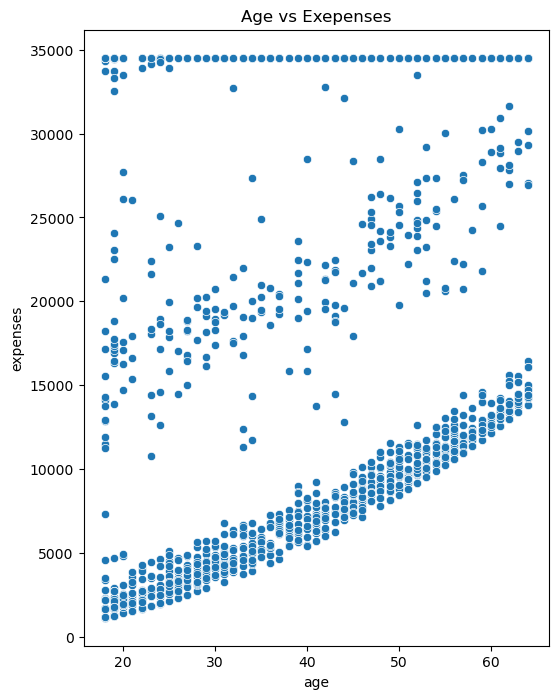

In [31]:
scatter_plot("age","expenses",data, "Age vs Exepenses")

People between age 50-60 years spends more on health insurance.

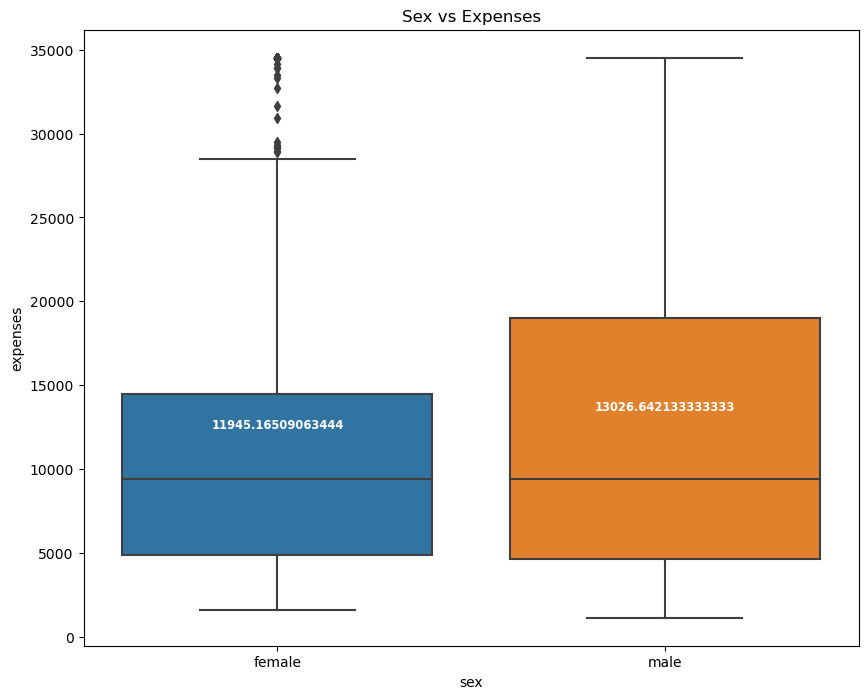

In [32]:
box_plot('sex','expenses',data,"Sex vs Expenses")

From the above plot we can see that males spends more on health insurance than females.
   

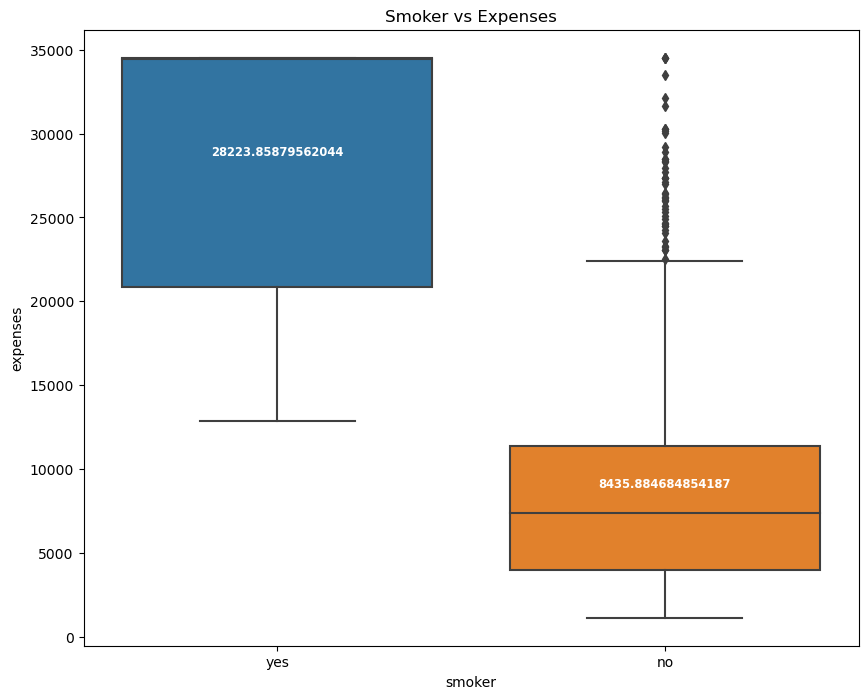

In [33]:
box_plot('smoker','expenses',data,"Smoker vs Expenses")

1. Smokers spends more on health insurance than non smokers.
2. On an average smokers spends 28223 on health insurance.
3. From the above plot we can say that non smokers spends 8435 on health insurance.
   But this might be impacted by outliers.


In [34]:
data_without_outlier_Nonsmoker = data[~((data['smoker']=='no') & (data['expenses'] > 21000))]

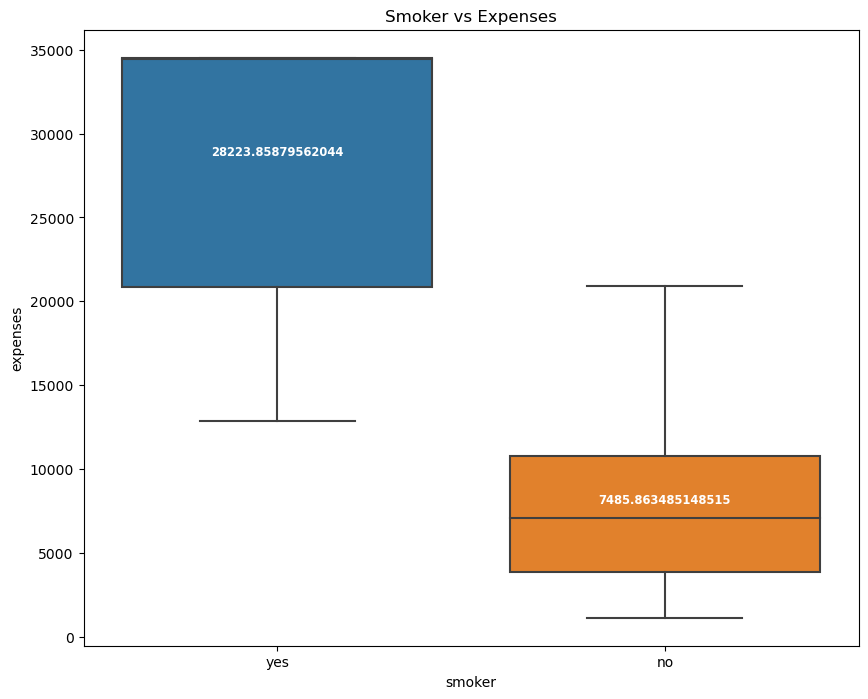

In [36]:
box_plot('smoker','expenses',data_without_outlier_Nonsmoker,"Smoker vs Expenses")

On an average non smoker spends 7485 on health insurance.

In [35]:
data_smokers = data[data['smoker']=='yes']

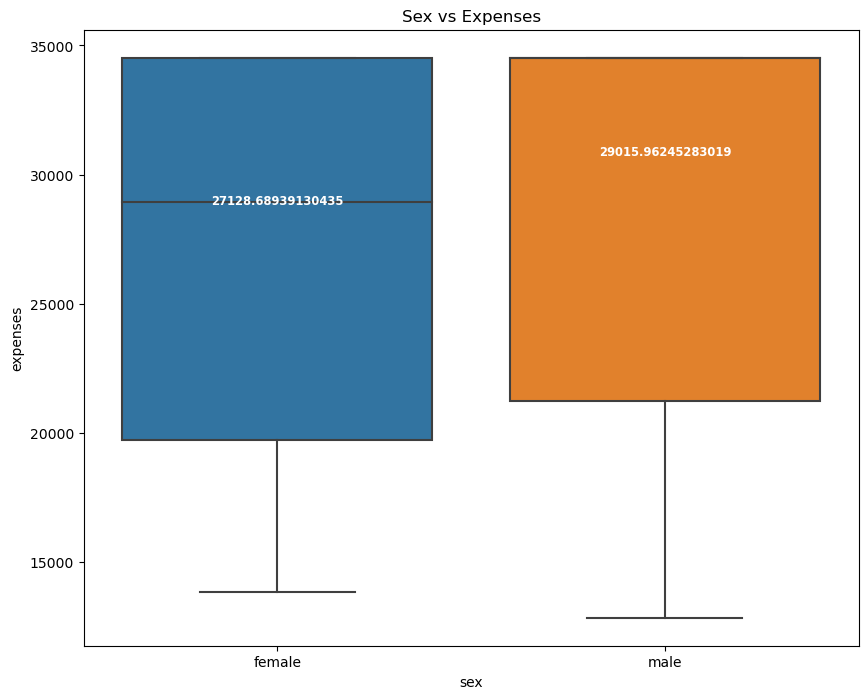

In [36]:
box_plot('sex','expenses',data_smokers,"Sex vs Expenses")

On an average males smokers spends more on health insurance than females.

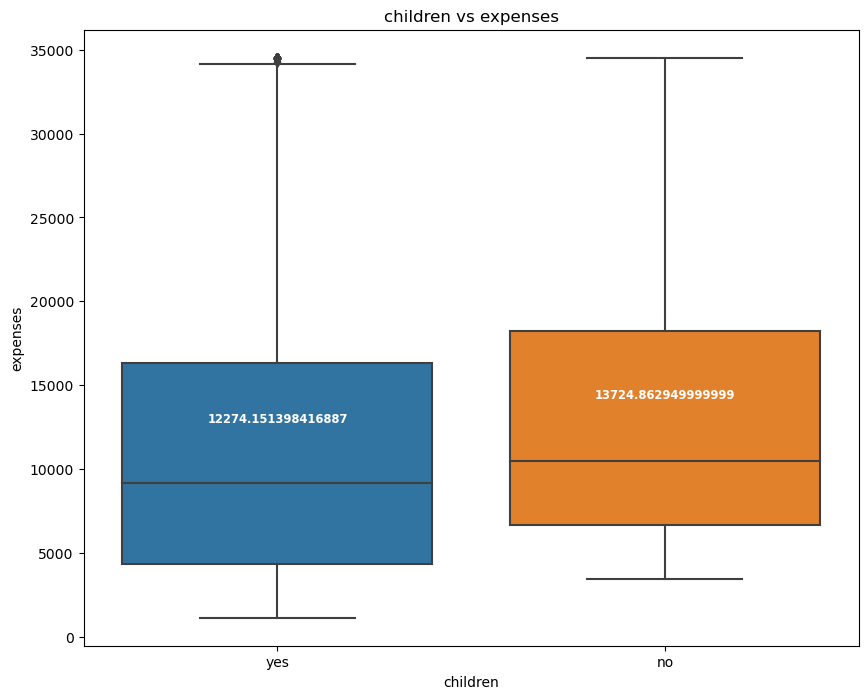

In [37]:
box_plot('children','expenses',data,"children vs expenses")

On an average people with more than two children spend more on health insurance.

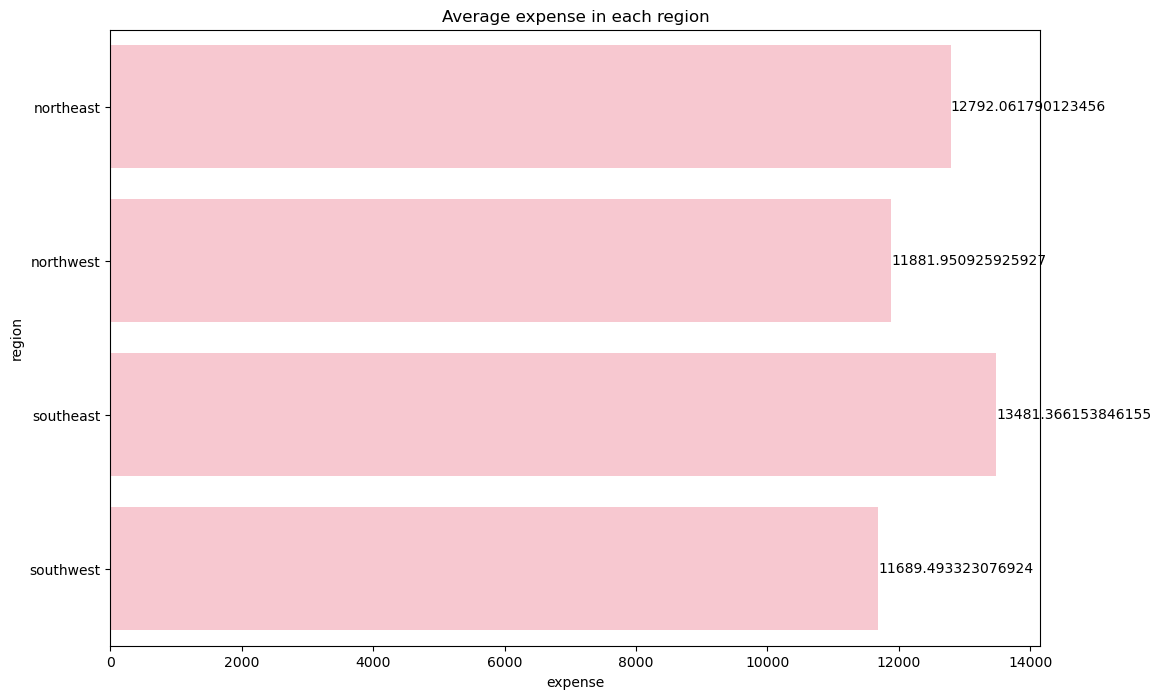

In [38]:
bar_plot('region',data,'Average expense in each region')

On an average people from southeast region spends more on health insurance.
Now lets check whether males in southeast region spends more on health insurance than females.

In [39]:
data_southeast = data[data['region'] == 'southeast']

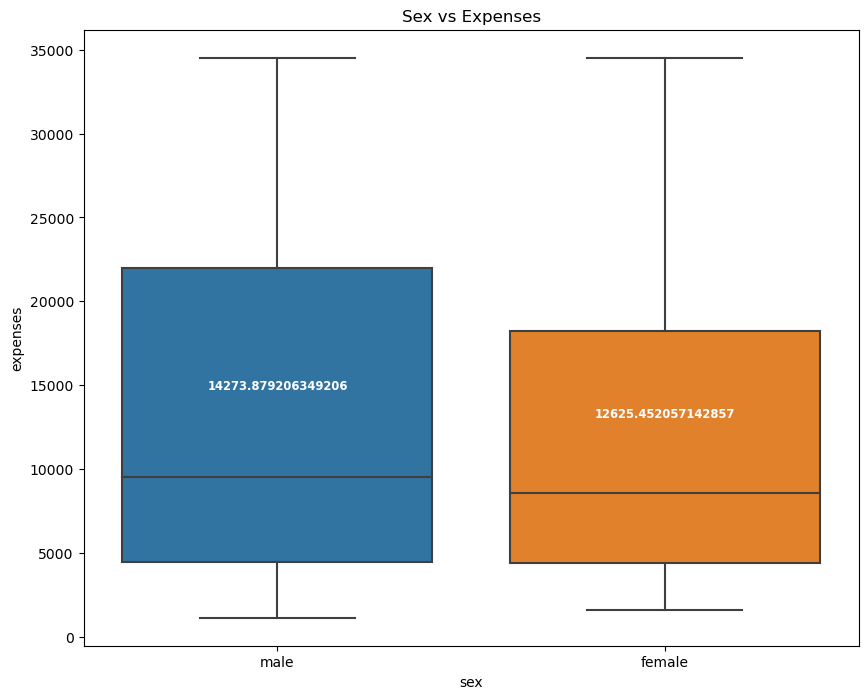

In [40]:
box_plot('sex','expenses',data_southeast,"Sex vs Expenses")

Males in southeast region spends more on health insurance.

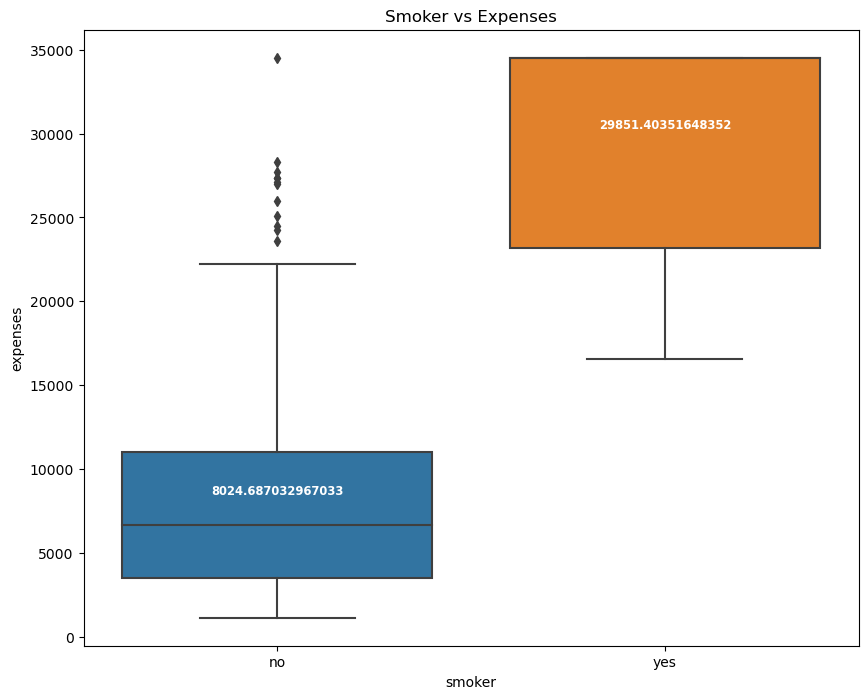

In [41]:
box_plot('smoker','expenses',data_southeast,"Smoker vs Expenses")

Smokers in southeast region spends more on health insurance.

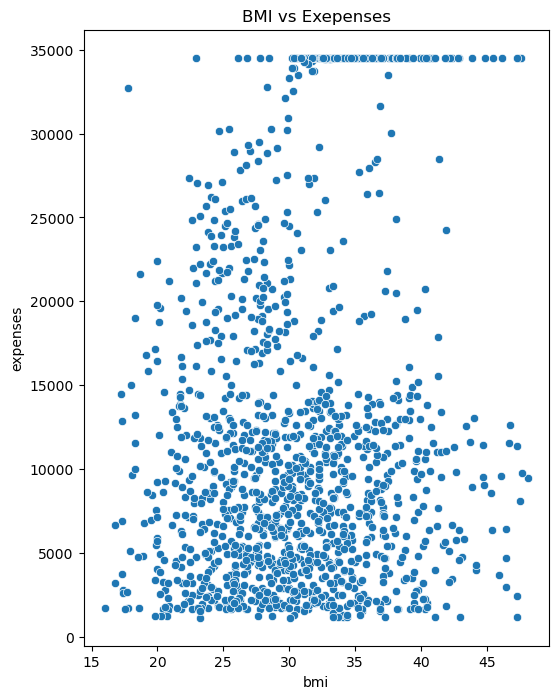

In [42]:
scatter_plot("bmi","expenses",data, "BMI vs Exepenses")

People with BMI between 30-45 spends more on health insurance.

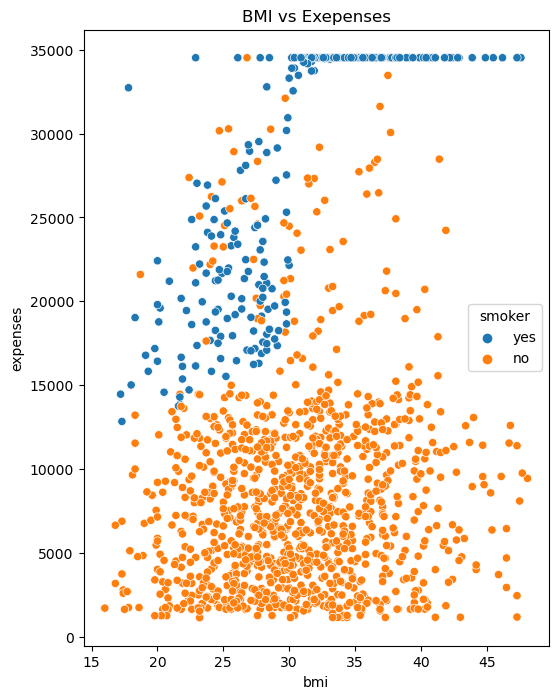

In [43]:
scatter_plot("bmi","expenses",data, "BMI vs Exepenses", huevalue='smoker')

Smokers with BMI between 30-45 spends between 30000 to 35000 on health insurance.

Below are the conclusions from above analysis.

1. People in southeast region spends more on medical expeses.
2. Males smokers spend more medical expenses health than female smokers.
3. Individuals wih BMI between 30-45 spend above 30000 on medical expenses.
4. People with more than 2 children spend more on medical expeses.

In [45]:
# Saving the data after EDA and basic pre-processing
data.to_csv("data_preprocessed.csv")

### Encode Categorical Features

In [46]:
data = pd.get_dummies(data,drop_first=True, dtype='int')

In [47]:
data.head()

,age,bmi,expenses,sex_male,children_yes,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.9,16884.92,0,1,1,0,0,1
1,18,33.8,1725.55,1,1,0,0,1,0
2,28,33.0,4449.46,1,0,0,0,1,0
3,33,22.7,21984.47,1,1,0,1,0,0
4,32,28.9,3866.86,1,1,0,1,0,0


### Split train and test data

In [48]:
X = data.drop(['expenses'],axis=1)
y = data['expenses']

In [49]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

In [50]:
x_train.shape

(1069, 8)

In [51]:
x_test.shape

(268, 8)

### Scaling numeric features

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train[['age','bmi']] = scaler.fit_transform(x_train[['age','bmi']])
x_test[['age','bmi']] = scaler.transform(x_test[['age','bmi']])

In [85]:
x_train

,age,bmi,sex_male,children_yes,smoker_yes,region_northwest,region_southeast,region_southwest
1114,-1.157680,-1.004456,1,1,0,0,0,0
968,-1.300619,-0.804482,1,1,0,0,0,0
599,0.914926,1.161936,0,1,0,1,0,0
170,1.701087,1.828518,1,1,0,0,1,0
275,0.557580,-0.654501,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1096,0.843457,0.745322,0,1,1,0,0,0
1131,-0.871804,2.561758,1,1,0,0,0,1
1295,-1.372088,-1.421070,1,1,0,0,0,1
861,-0.085643,-0.421197,0,0,0,0,0,1


### Utility Functions

In [54]:
RMSE = {}
R2_Score = {}

In [55]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(X_train, y_train,X_test,y_test,model,param):
    gs = GridSearchCV(model,param,cv=5)
    gs.fit(X_train,y_train)
    model.set_params(**gs.best_params_)
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return model ,y_train_pred, y_test_pred

In [56]:
def actual_vs_pred_plot(y_actual,y_pred,title=None):
    plt.figure(figsize=(6,8))    
    ax = sns.scatterplot(x=y_pred, y=y_actual)
    ax.set_xlabel("predicted values")
    ax.set_ylabel("actual values")
    ax.set_title(title)
    plt.show()
    

In [57]:
def model_perf_plot(y_train,y_train_pred,y_test,y_test_pred):
    f, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
    axes[0].scatter(x=y_train_pred, y=y_train,c='y')
    axes[0].set_title('Actual vs Predicted Plot for Training data')
    axes[0].grid()
    axes[0].set_xlabel("predicted values")
    axes[0].set_ylabel("actual values")
  
    axes[1].scatter(x=y_test_pred, y=y_test,c='g')
    axes[1].set_title('Actual vs Predicted Plot for Test data')
    axes[1].grid()
    axes[1].set_xlabel("predicted values")
    axes[1].set_ylabel("actual values")
    
    plt.subplots_adjust(wspace=0.50, hspace=0.1)
    plt.show()

In [58]:
def check_normality_residuals(residuals_train,residuals_test):
    f, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
    axes[0].hist(residuals_train)
    axes[1].hist(residuals_test)
    plt.subplots_adjust(wspace=0.50, hspace=0.1)
    plt.show()
    

RMSE  with LinearRegression() on train data is 5254.388838955943
RMSE  with LinearRegression() on test data is 4587.793408186868
R square  with LinearRegression() on train data is 0.723226989147722
R square  with LinearRegression() on test data is 0.8198786179140045


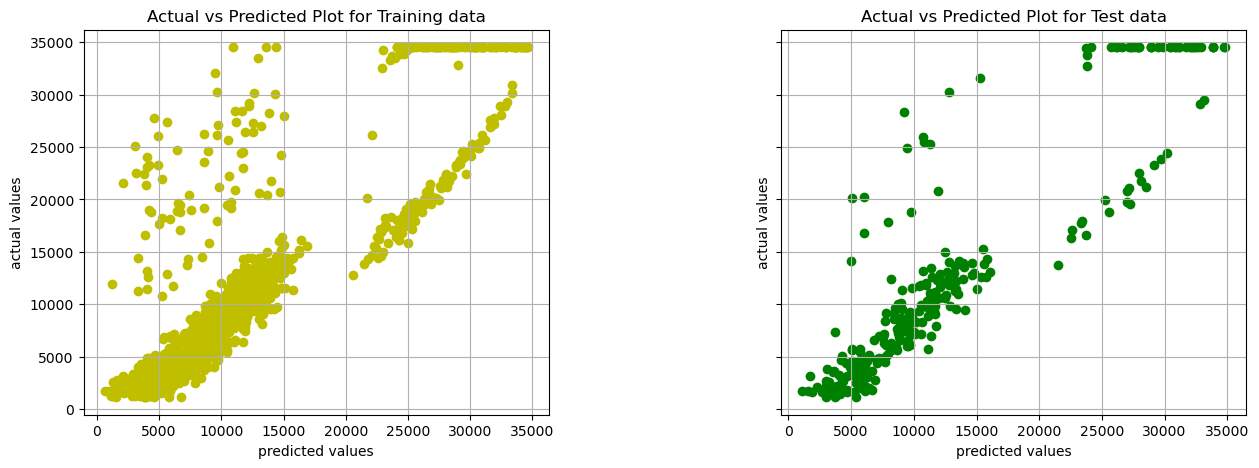

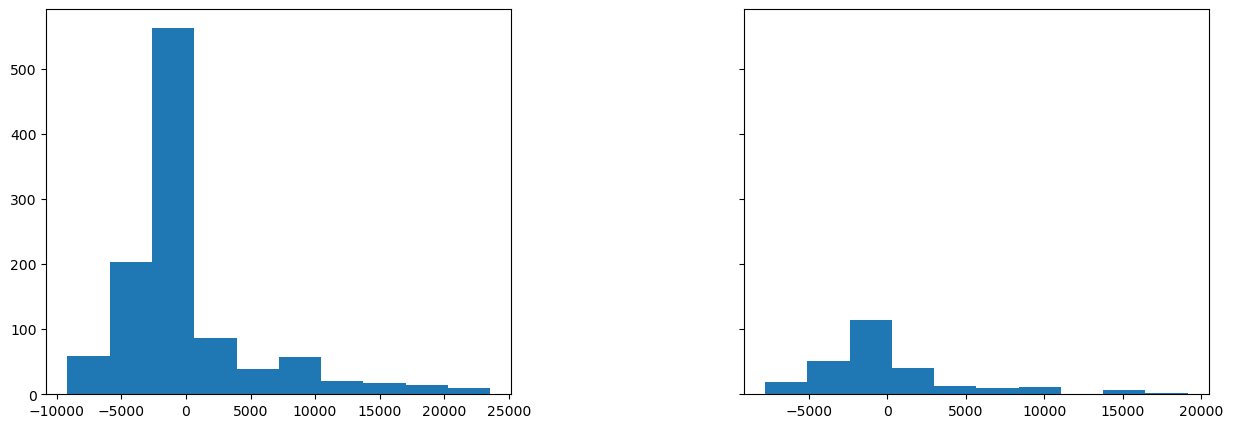

In [87]:
model  = LinearRegression()
#param =  {'alpha': [0.1,0.5,1,1.5,2]}
model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

#model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)

rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

check_normality_residuals(residuals_train,residuals_test)

### Validating assumptions of Linear Regression Model

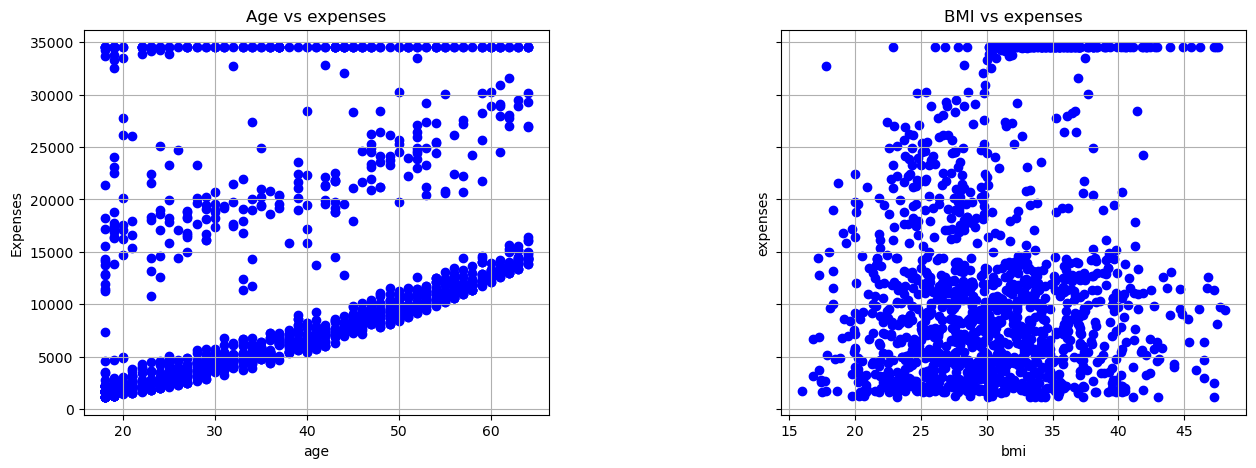

In [89]:
## There should be linear relationship between independent and target variables.
## Lets check relationship between age and expenses and BMI and expenses using scatter plot
f, axes = plt.subplots(1, 2, figsize=(15, 5),sharey=True)
axes[0].scatter(x=data['age'], y=data['expenses'],c='b')
axes[0].set_title('Age vs expenses')
axes[0].grid()
axes[0].set_xlabel("age")
axes[0].set_ylabel("Expenses")

axes[1].scatter(x=data['bmi'], y=data['expenses'],c='b')
axes[1].set_title('BMI vs expenses')
axes[1].grid()
axes[1].set_xlabel("bmi")
axes[1].set_ylabel("expenses")

plt.subplots_adjust(wspace=0.50, hspace=0.1)
plt.show()

RMSE  with Ridge(alpha=1.5) on train data is 5254.850403342942
RMSE  with Ridge(alpha=1.5) on test data is 4599.610846145504
R square  with Ridge(alpha=1.5) on train data is 0.7231783615413709
R square  with Ridge(alpha=1.5) on test data is 0.8189494938214302


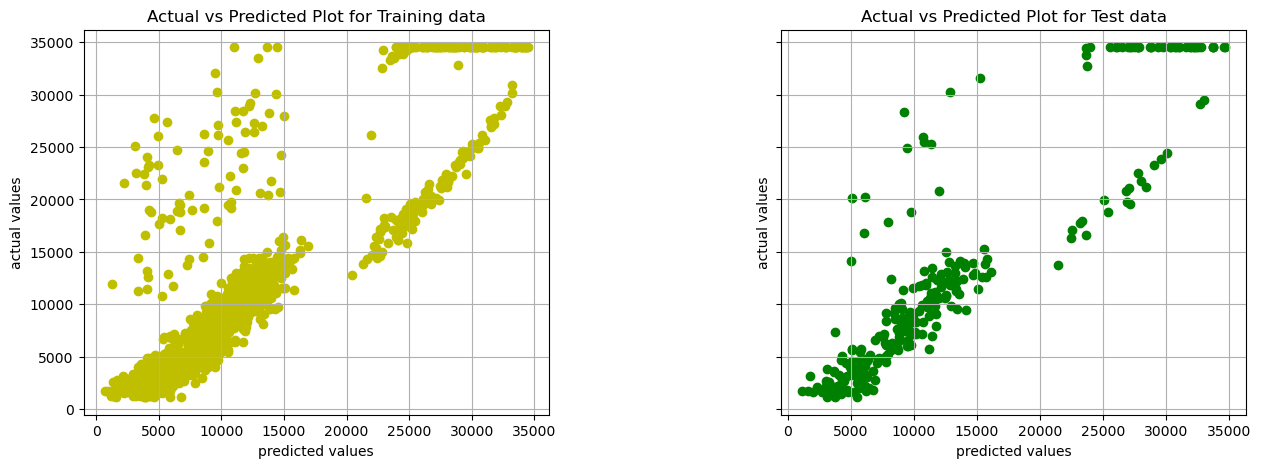

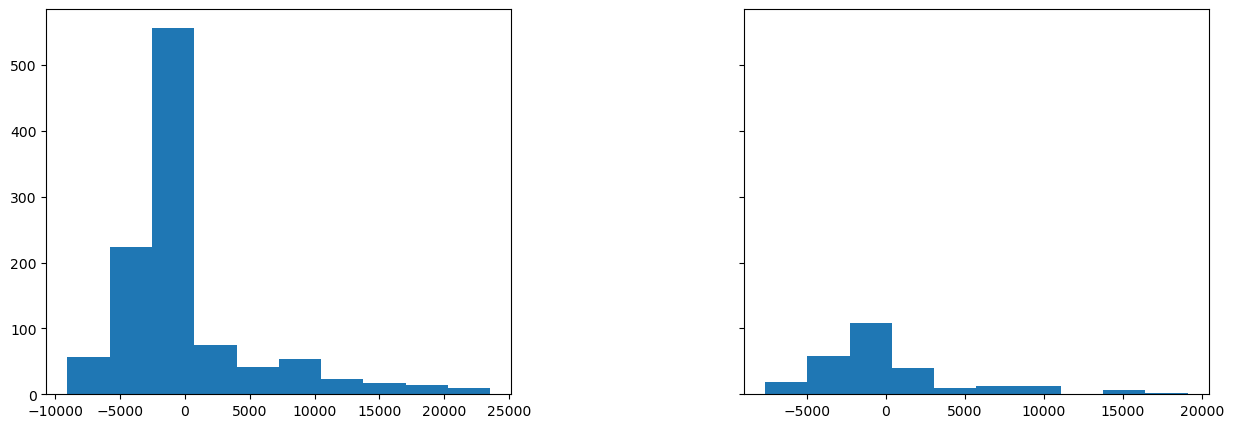

In [59]:
model  = Ridge()
param =  {'alpha': [0.1,0.5,1,1.5,2]}
model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)

rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

check_normality_residuals(residuals_train,residuals_test)

RMSE  with Lasso(alpha=2) on train data is 5254.4169247759755
RMSE  with Lasso(alpha=2) on test data is 4590.331343846669
R square  with Lasso(alpha=2) on train data is 0.7232240303192127
R square  with Lasso(alpha=2) on test data is 0.8196792789811547


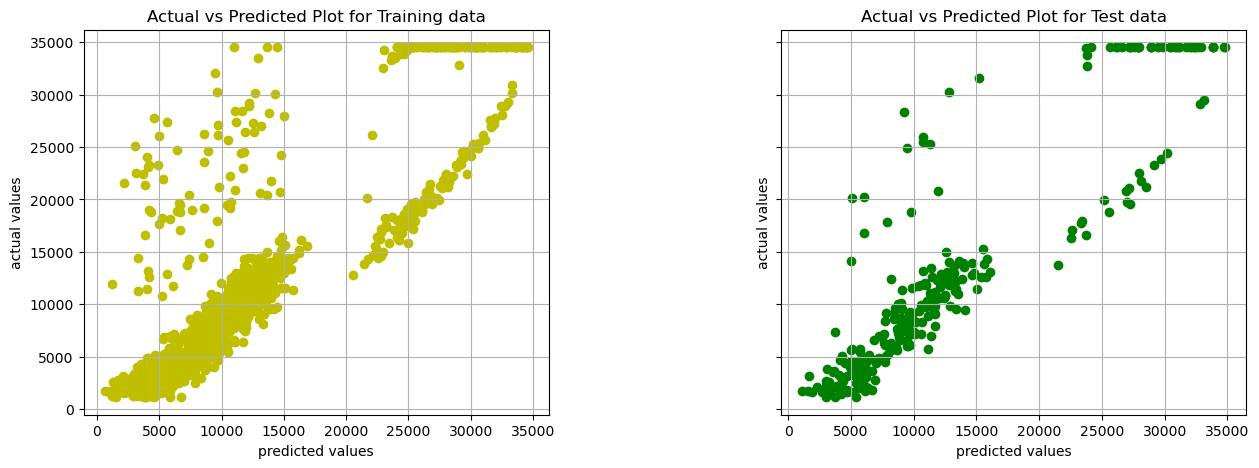

In [60]:
model  = Lasso()
param =  {'alpha': [0.1,0.5,1,1.5,2]}

model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)
rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)

In [63]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

RMSE  with DecisionTreeRegressor(max_depth=9, max_features='log2', min_samples_split=8) on train data is 3905.285138379
RMSE  with DecisionTreeRegressor(max_depth=9, max_features='log2', min_samples_split=8) on test data is 4490.861903954141
R square  with DecisionTreeRegressor(max_depth=9, max_features='log2', min_samples_split=8) on train data is 0.8471079800493572
R square  with DecisionTreeRegressor(max_depth=9, max_features='log2', min_samples_split=8) on test data is 0.8274094687324187


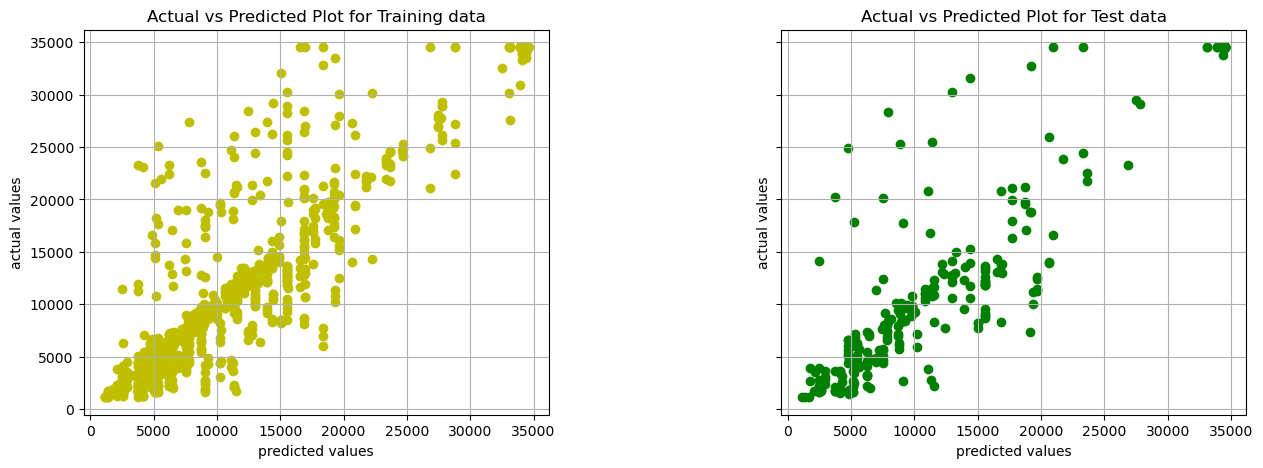

In [75]:
from sklearn.tree import DecisionTreeRegressor
model  = DecisionTreeRegressor()

param =  {'max_features': ["sqrt", "log2"],
           'max_depth' : [8,9,10,12],
           'min_samples_split' : [2,4,6,8]}

model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)
rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)

In [68]:
model.get_depth()

8

RMSE  with RandomForestRegressor(max_depth=8, n_estimators=20) on train data is 3059.6314439779676
RMSE  with RandomForestRegressor(max_depth=8, n_estimators=20) on test data is 4002.0149061494985
R square  with RandomForestRegressor(max_depth=8, n_estimators=20) on train data is 0.9061536141369622
R square  with RandomForestRegressor(max_depth=8, n_estimators=20) on test data is 0.862938661602703


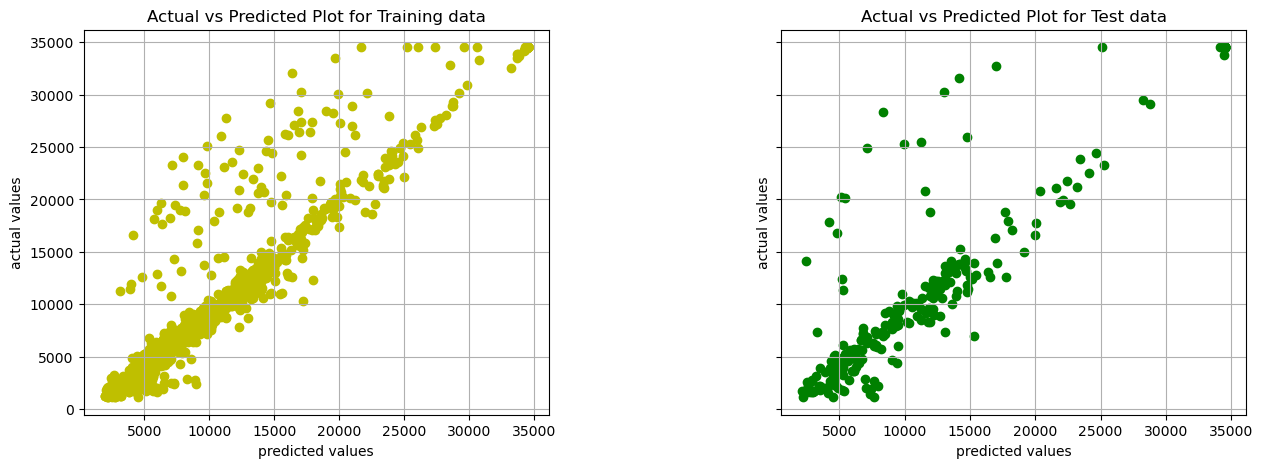

In [77]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor
model  = RandomForestRegressor()

param =  {'n_estimators': [10,20,30,50,80,100],
           'max_depth' : [8,9,10,12]}

model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)
rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)


RMSE  with GradientBoostingRegressor(n_estimators=30) on train data is 4274.774876843921
RMSE  with GradientBoostingRegressor(n_estimators=30) on test data is 3814.7380837898904
R square  with GradientBoostingRegressor(n_estimators=30) on train data is 0.8168082895334458
R square  with GradientBoostingRegressor(n_estimators=30) on test data is 0.875466264679782


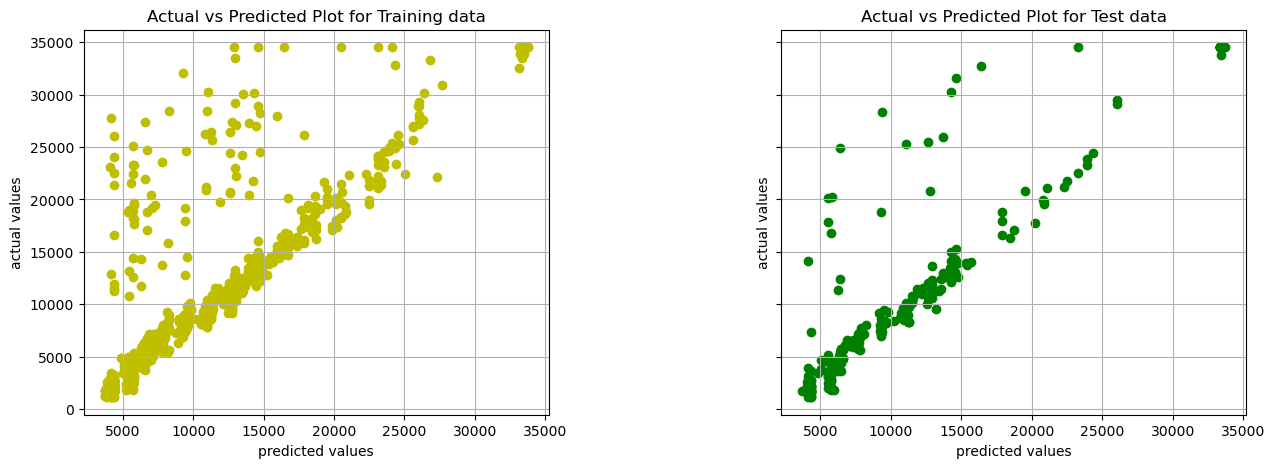

In [80]:
from sklearn.ensemble import GradientBoostingRegressor
model  = GradientBoostingRegressor()

param =  {'n_estimators': [10,20,30,50,100]}
           #'learning_rate' : [0.01,0.05,0.1,0.5,1]}

model ,y_train_pred, y_test_pred = evaluate_model(x_train, y_train,x_test,y_test,model,param)
rmse_train = mean_squared_error(y_train,y_train_pred,squared=False)
rmse_test = mean_squared_error(y_test,y_test_pred,squared=False)
r2_score_train = r2_score(y_train,y_train_pred)
r2_score_test = r2_score(y_test,y_test_pred)

RMSE[model] = rmse_test
R2_Score[model] = r2_score_test

print(f'RMSE  with {model} on train data is {rmse_train}')
print(f'RMSE  with {model} on test data is {rmse_test}')
print(f'R square  with {model} on train data is {r2_score_train}')
print(f'R square  with {model} on test data is {r2_score_test}')

model_perf_plot(y_train,y_train_pred,y_test,y_test_pred)